# 1.6b: Cluster-Perspective Sky Map

This notebook visualizes the universe from the cluster's perspective, with point size encoding radial distance.

## The Question

We've identified a tight cluster of 2,212 tokens and seen that the remaining ~18,161 non-cluster tokens show a flat radial density profile (1.5c). But is the distribution **isotropic**?

From the cluster's point of view:
- Do nearby tokens cluster in certain directions?
- Are there voids or overdensities at specific angles?
- Does the surrounding gas have structure, or is it uniform?

**Visual encoding:**
- **Position:** Angular coordinates (latitude, longitude) from cluster centroid
- **Size:** Radial distance from cluster (close = big, far = small)
- **Color:** Monochrome (all non-cluster tokens same color)

If the surrounding gas is truly uniform background, we should see:
- Even coverage across all directions
- Smooth gradation of sizes (no shells or discrete layers)
- No preferred axes or hot spots

## Method

We'll:
1. Load cluster-centric reference frame (centroid + PCA basis)
2. Load cluster and overdensity token IDs
3. Compute spherical coordinates from cluster centroid
4. Filter to non-cluster tokens only
5. Scale point sizes by radial distance (inverse linear)
6. Plot: Mollweide and polar projections

## Parameters

In [131]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# PCA basis selection (for spherical coordinates)
NORTH_PC = 2
MERIDIAN_PC = 1
EQUINOX_PC = 3

# Point size scaling
BASE_SIZE = 500  # Maximum size (for closest tokens)
ALPHA = 1     # Transparency

# Color
POINT_COLOR = 'steelblue'

# Visualization
FIGSIZE = (16, 8)
DPI = 200

## Imports

In [132]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Device Detection

In [133]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [134]:
# Load W
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]
W = W_bf16.to(torch.float32).to(device)
N, d = W.shape

print(f"Loaded W: {W.shape}")

Loaded W: torch.Size([151936, 2560])


In [135]:
# Load cluster-centric reference frame
ref_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_reference_frame.safetensors")
ref_data = load_file(ref_path)
cluster_centroid = ref_data['cluster_centroid'].to(device)
eigenvectors = ref_data['W_eigenvectors'].to(device)

print(f"\nLoaded reference frame:")
print(f"  Cluster centroid: {cluster_centroid.shape}")
print(f"  Centroid norm: {torch.linalg.vector_norm(cluster_centroid).item():.6f}")
print(f"  PCA eigenvectors: {eigenvectors.shape}")


Loaded reference frame:
  Cluster centroid: torch.Size([2560])
  Centroid norm: 0.370917
  PCA eigenvectors: torch.Size([2560, 2560])


In [136]:
# Load overdensity token IDs
overdensity_path = Path(f"../tensors/{MODEL_NAME}/1.4b_overdensity_distances.safetensors")
overdensity_data = load_file(overdensity_path)
spike_token_ids = overdensity_data['spike_token_ids'].to(device)

print(f"\nLoaded {len(spike_token_ids):,} overdensity tokens")


Loaded 20,373 overdensity tokens


In [137]:
# Load cluster token IDs
cluster_path = Path(f"../tensors/{MODEL_NAME}/1.4h_cluster_tokens.safetensors")
cluster_data = load_file(cluster_path)
cluster_token_ids = cluster_data['cluster_token_ids']

print(f"\nLoaded {len(cluster_token_ids):,} cluster tokens")


Loaded 2,212 cluster tokens


## Define Spherical Basis

In [138]:
def get_pc_vector(pcs, index):
    """Get PC vector by index, with sign flip for negative indices."""
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

print(f"\nSpherical basis defined:")
print(f"  North: PC{NORTH_PC}")
print(f"  Meridian: PC{MERIDIAN_PC}")
print(f"  Equinox: PC{EQUINOX_PC}")


Spherical basis defined:
  North: PC2
  Meridian: PC1
  Equinox: PC3


## Compute Spherical Coordinates from Cluster Centroid

In [139]:
print("\nComputing spherical coordinates from cluster centroid...\n")

# Get overdensity vectors
spike_vecs = W[spike_token_ids]

# Translate to cluster-centric frame
spike_vecs_centered = spike_vecs - cluster_centroid

# Project onto basis
x = spike_vecs_centered @ meridian
y = spike_vecs_centered @ equinox
z = spike_vecs_centered @ north

# Spherical coordinates
r = torch.sqrt(x**2 + y**2 + z**2)
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print(f"✓ Spherical coordinates computed")
print(f"\nRadial distance statistics:")
print(f"  Min: {r.min().item():.6f}")
print(f"  Max: {r.max().item():.6f}")
print(f"  Mean: {r.mean().item():.6f}")
print(f"  Median: {r.median().item():.6f}")


Computing spherical coordinates from cluster centroid...

✓ Spherical coordinates computed

Radial distance statistics:
  Min: 0.000000
  Max: 0.226434
  Mean: 0.063148
  Median: 0.063239


## Filter to Non-Cluster Tokens

In [140]:
print("\nFiltering to non-cluster tokens...\n")

# Create mask: which spike tokens are in the cluster?
in_cluster = torch.isin(spike_token_ids, cluster_token_ids.to(device))

# Filter to non-cluster only
noncluster_mask = ~in_cluster

lat_deg_noncluster = lat_deg[noncluster_mask]
lon_deg_noncluster = lon_deg[noncluster_mask]
r_noncluster = r[noncluster_mask]

print(f"✓ Filtered to non-cluster tokens")
print(f"  Total overdensity: {len(spike_token_ids):,}")
print(f"  Cluster: {in_cluster.sum().item():,}")
print(f"  Non-cluster: {noncluster_mask.sum().item():,}")


Filtering to non-cluster tokens...

✓ Filtered to non-cluster tokens
  Total overdensity: 20,373
  Cluster: 2,212
  Non-cluster: 18,161


## Compute Point Sizes

In [141]:
print("\nComputing point sizes...\n")

# Convert to numpy
r_np = r_noncluster.cpu().numpy()
lat_np = lat_deg_noncluster.cpu().numpy()
lon_np = lon_deg_noncluster.cpu().numpy()

# Inverse square scaling: close = MUCH bigger, far = much smaller
# size ∝ 1/r² (angular area scaling)
r_max = r_np.max()
r_min = r_np.min()

# Normalize distances to [0, 1] range
r_normalized = (r_np - r_min) / (r_max - r_min)

# Inverse square with offset to prevent division by zero
# Add small epsilon, invert, square
epsilon = 0.01
sizes = BASE_SIZE * (1 / (r_normalized + epsilon))**2

# Rescale to reasonable range
sizes = sizes / sizes.max() * BASE_SIZE

print(f"✓ Point sizes computed")
print(f"  Size range: [{sizes.min():.2f}, {sizes.max():.2f}]")
print(f"  Mean size: {sizes.mean():.2f}")


Computing point sizes...

✓ Point sizes computed
  Size range: [0.05, 500.00]
  Mean size: 2.34


## Mollweide Sky Map


Creating Mollweide sky map...



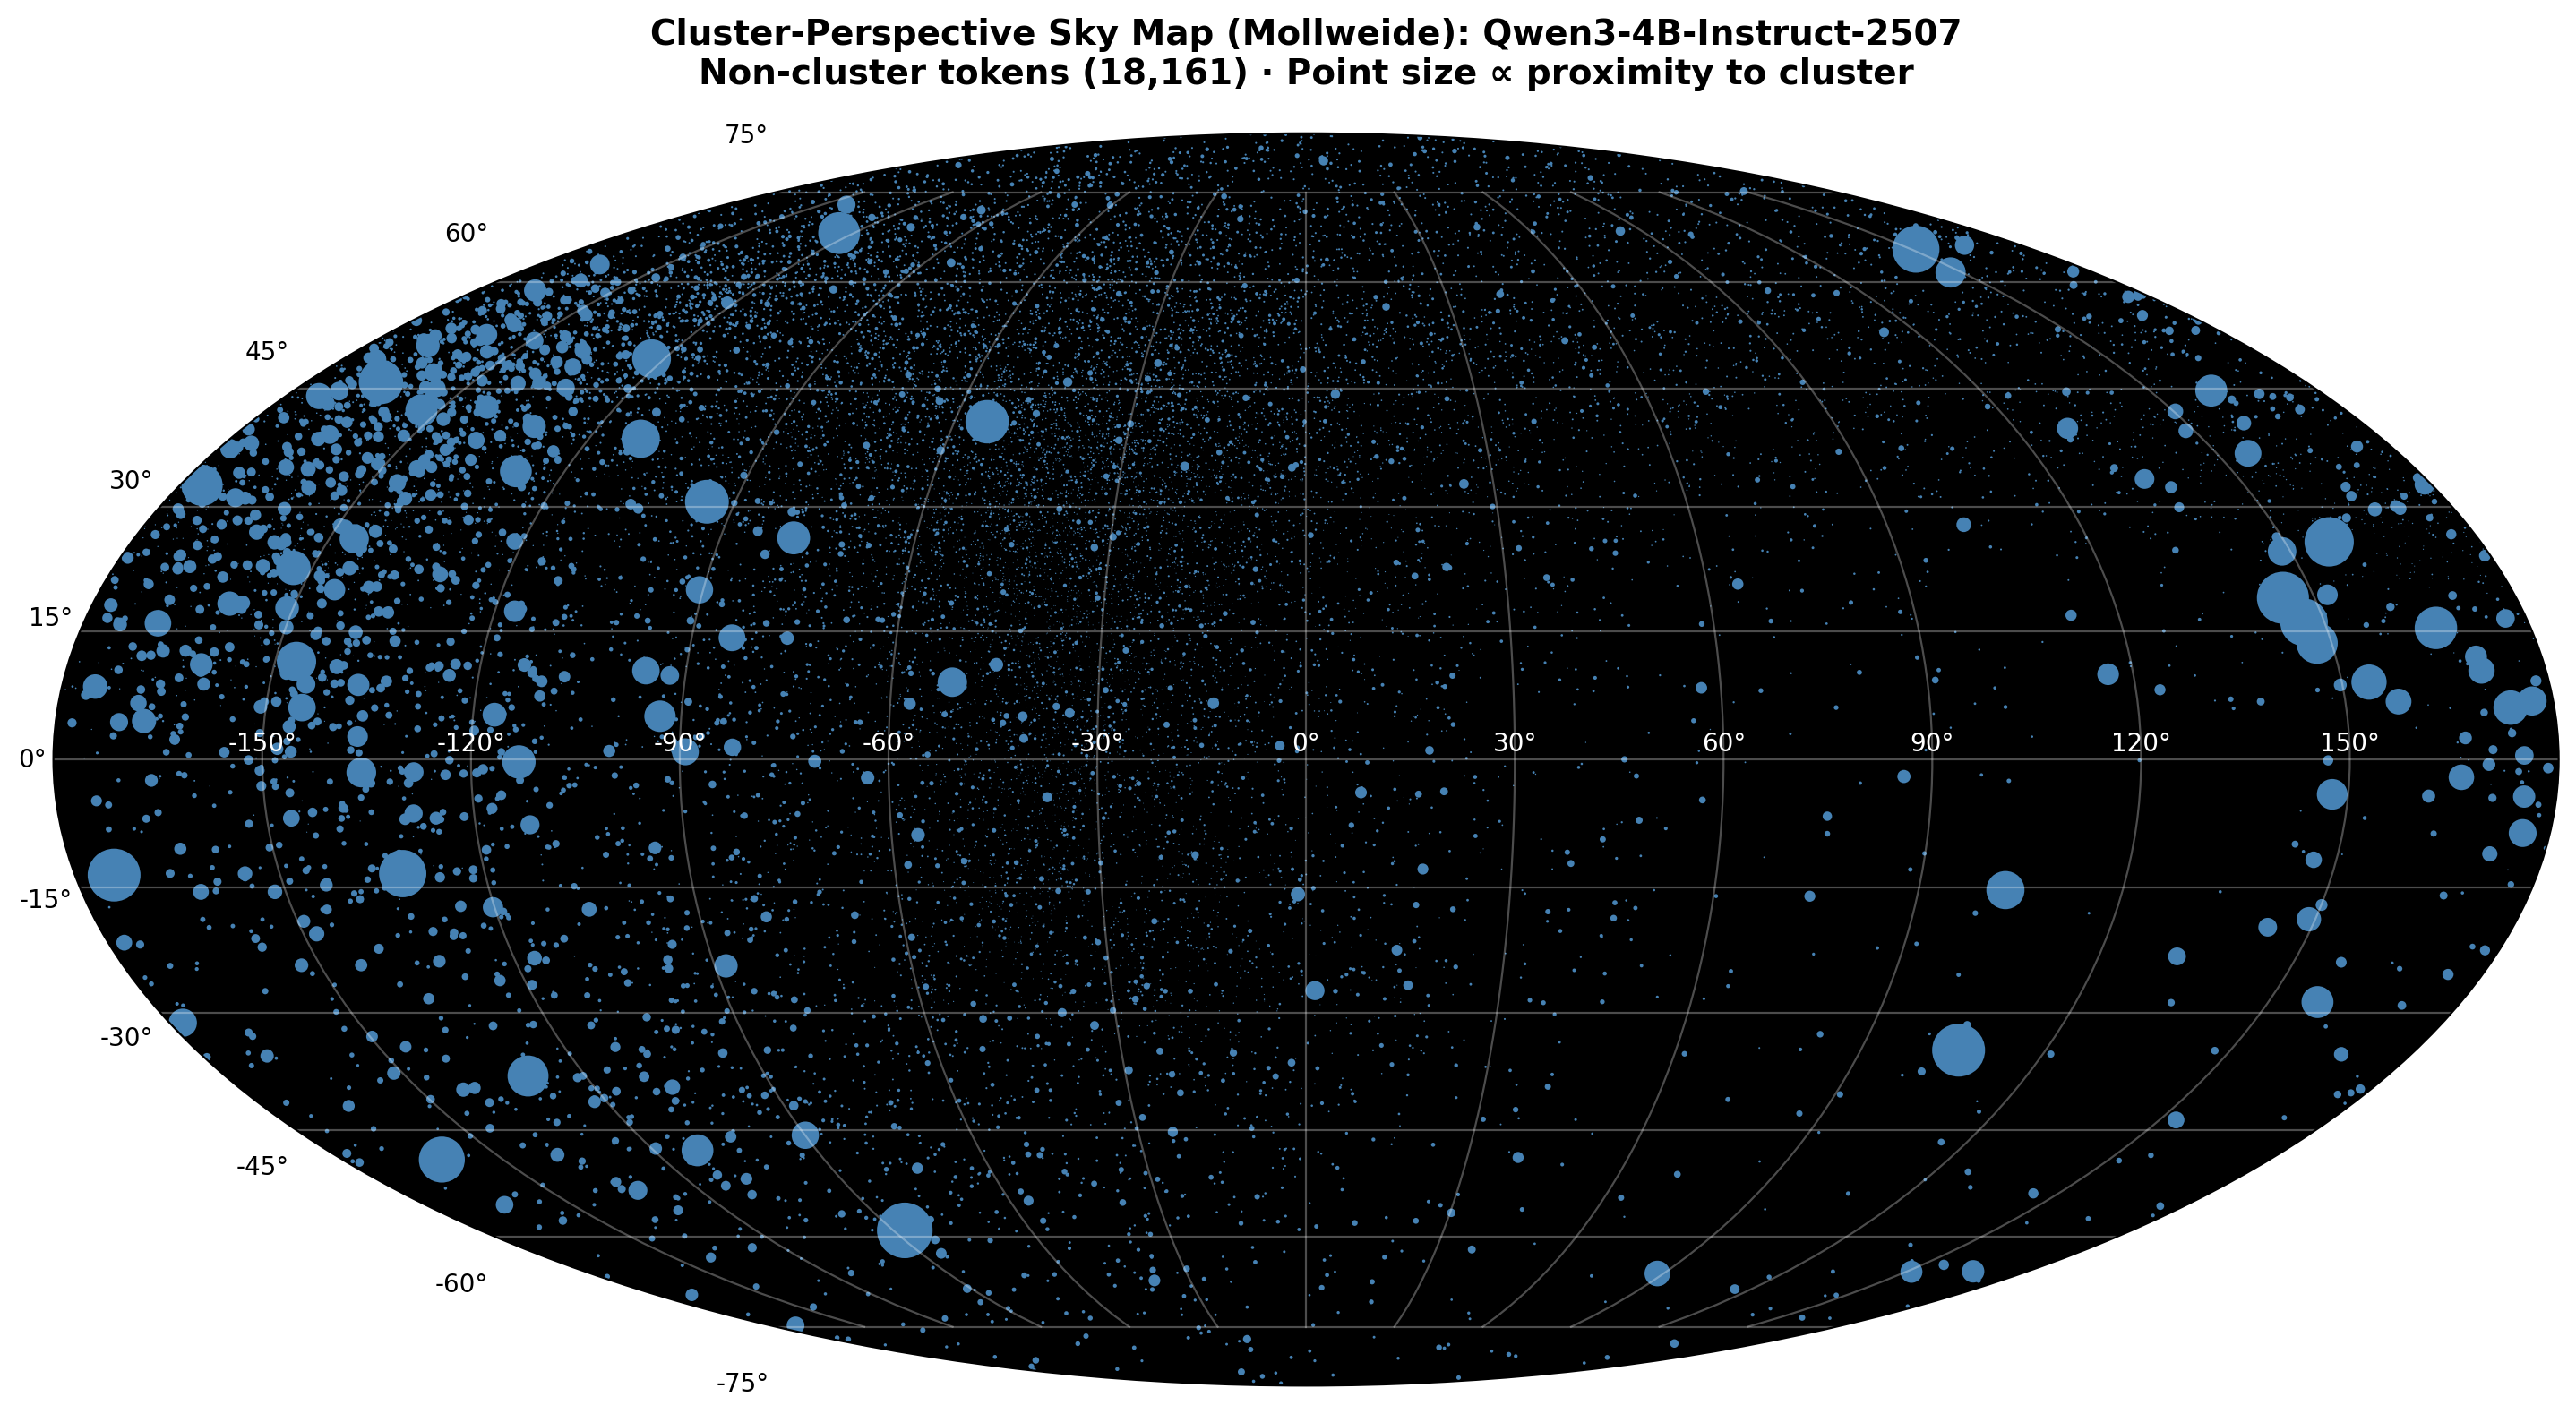

✓ Mollweide sky map complete


In [142]:
print(f"\nCreating Mollweide sky map...\n")

# Convert to radians for plotting
lon_rad = np.deg2rad(lon_np)
lat_rad = np.deg2rad(lat_np)

# Create figure
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
ax = fig.add_subplot(111, projection='mollweide')
ax.set_facecolor('black')

# Scatter plot
ax.scatter(lon_rad, lat_rad, 
           s=sizes, 
           alpha=ALPHA, 
           c=POINT_COLOR,
           edgecolors='none',
           rasterized=True)

# Formatting
ax.grid(True, alpha=0.3, color='white')
ax.set_title(f'Cluster-Perspective Sky Map (Mollweide): {MODEL_NAME}\n' + 
             f'Non-cluster tokens ({noncluster_mask.sum().item():,}) · Point size ∝ proximity to cluster',
             color='black', pad=20, fontsize=14, fontweight='bold')

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('black')

plt.tight_layout()
plt.show()

print("✓ Mollweide sky map complete")

## Polar (Equatorial) Sky Map


Creating polar sky map...



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_93106/441302982.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])


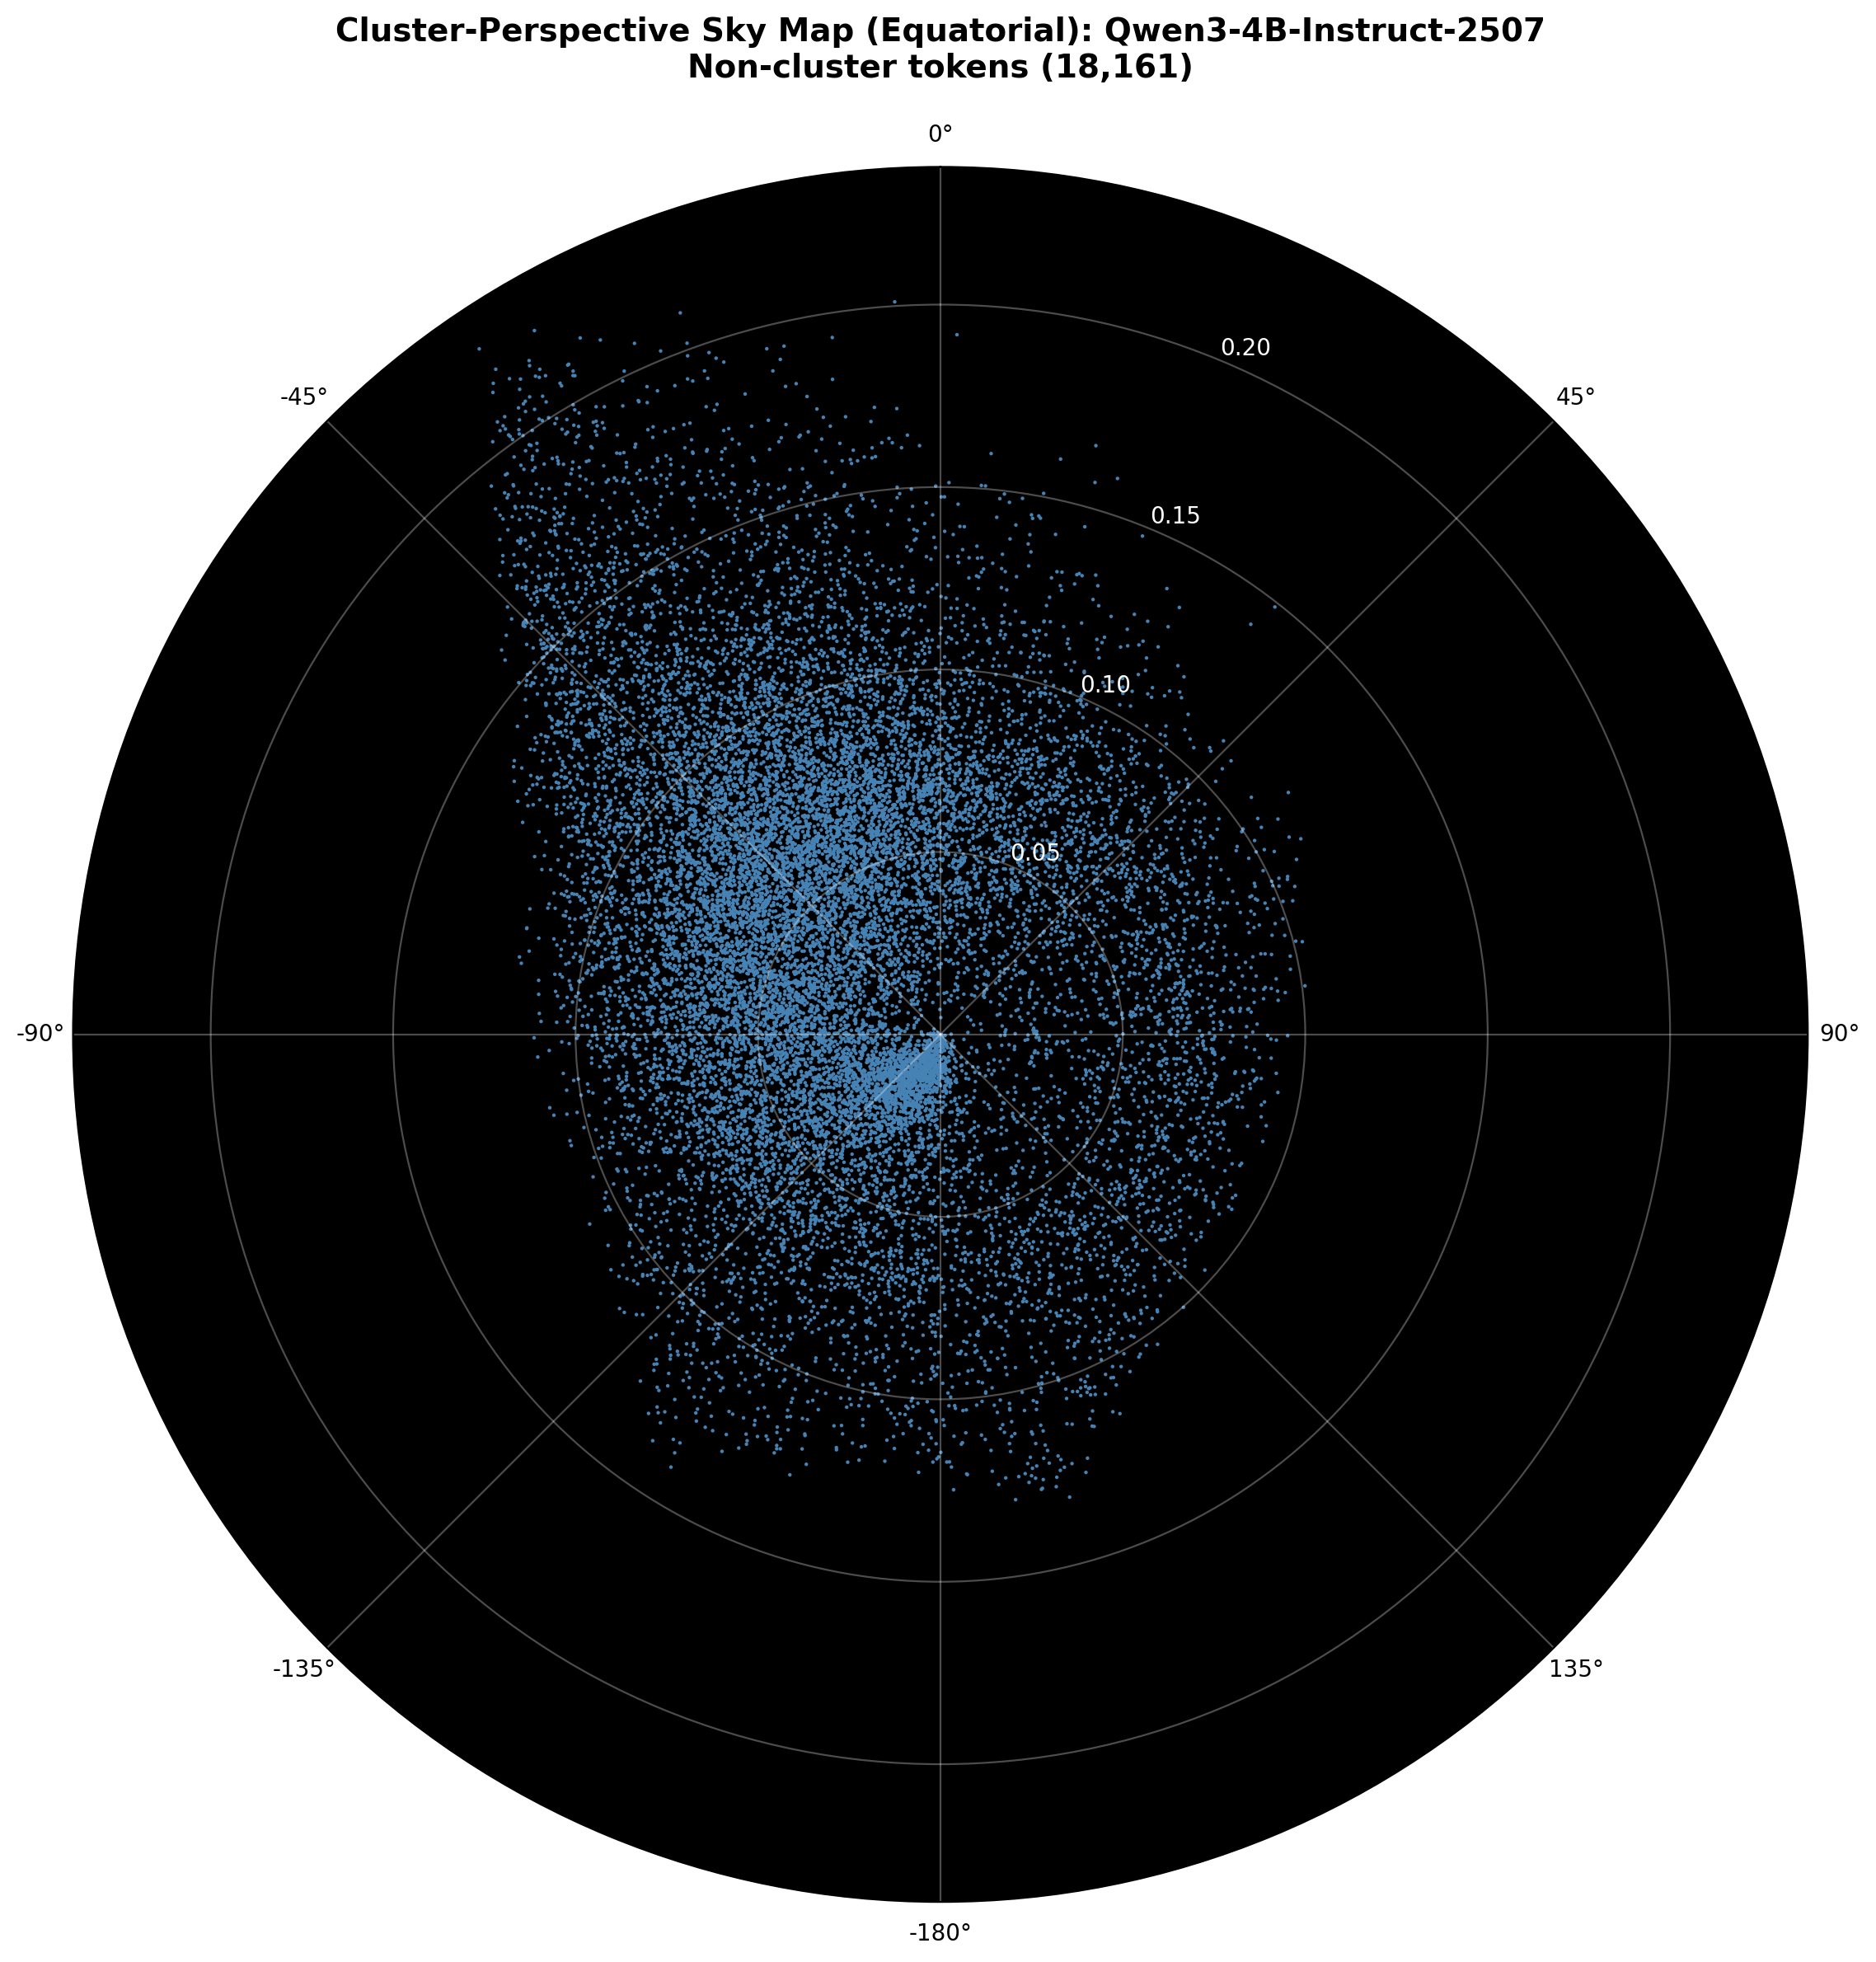

✓ Polar sky map complete


In [148]:
print(f"\nCreating polar sky map...\n")

# Create figure
fig = plt.figure(figsize=(12, 12), dpi=DPI)
ax = fig.add_subplot(111, projection='polar')
ax.set_facecolor('black')

# Scatter plot
ax.scatter(lon_rad, r_np, 
           s=2.5, 
           alpha=ALPHA, 
           c=POINT_COLOR,
           edgecolors='none',
           rasterized=True)

# Formatting
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.grid(True, alpha=0.3, color='white')
ax.set_title(f'Cluster-Perspective Sky Map (Equatorial): {MODEL_NAME}\n' + 
             f'Non-cluster tokens ({noncluster_mask.sum().item():,})',
             color='black', pad=20, fontsize=14, fontweight='bold')

# Get the default tick positions (in radians)
tick_locs = ax.get_xticks()

# Convert each tick from radians to degrees
tick_degs = np.rad2deg(tick_locs)

# Wrap to -180 to 180 range
tick_degs = ((tick_degs + 180) % 360) - 180

# Set the labels (but keep original positions)
ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('black')
for label in ax.get_yticklabels():
    label.set_color('white')

# ax.set_ylim(bottom=0, top=0.05)

plt.tight_layout()
plt.show()

print("✓ Polar sky map complete")

## Observations

Look for:

**Isotropy (uniform background):**
- Even coverage across all directions
- No preferred axes or hot spots
- Smooth gradation of sizes (no shells)
- "Ice cube floating in diffuse gas" confirmed

**Anisotropy (structure):**
- Overdensities at specific angles (clumps of large points)
- Voids (empty patches)
- Shells (rings of similar-sized points)
- Filaments or streams (linear features)

**Depth structure:**
- Point size reveals radial layering
- Large points (nearby) vs small points (distant)
- Are nearby tokens randomly distributed or clustered?

If the distribution is isotropic, the cluster is truly an isolated condensate in otherwise uniform token space. If there's anisotropy, it suggests the cluster is part of a larger structure (thermal halo, filament, or multi-cluster system).